本测试将使用 [博时标普500ETF(QDII)](https://gu.qq.com/sh513500) 对 **周内效应** 进行验证。

> 周内效应：http://erj.cn/UploadFiles/%E4%B8%AD%E5%9B%BD%E8%82%A1%E7%A5%A8%E5%B8%82%E5%9C%BA%E7%9A%84_%E5%91%A8%E5%86%85%E6%95%88%E5%BA%94_.pdf

> 规则说明及其他说明参考 [ETF-周内效应-510310](ETF-周内效应-510310.ipynb)。

验证时对应基准采用[GSPC](https://finance.yahoo.com/quote/%5EGSPC?p=^GSPC&.tsrc=fin-srch)

### 结论

* **完全没有看到跑赢基准的迹象**。完整时跑赢基准的可能性为`30%+`，拆分后提升至接近`50%`。
* 盈利可能由完整时的`60%`左右提升至`70%+`。

In [1]:
import logging
logging.disable(logging.INFO)

import numpy as np
import talib
import pandas as pd
from tqdm import tqdm_notebook
import gquant
import abupy
import QUANTAXIS as QA
import gquant.jupyter_helper
gquant.jupyter_helper.init()
import matplotlib.pyplot as plt
import seaborn as sns
from gquant.backtest import backtest
from gquant.week_effect import *

plt.style.use('ggplot')

you are using non-interactive mdoel quantaxis


In [2]:
CODE='513500' #标普500
BENCHMARK_CODE='GSPC' #https://finance.yahoo.com/quote/%5EGSPC?p=^GSPC&.tsrc=fin-srch
START='2013-12-05'
END='2021-05-06' #NDX 指数截止日期。更新时需要使用yfinance获取数据。https://pypi.org/project/yfinance/
INIT_CASH=10000#验证时的模拟初始资金
DEFAULT_MA=20#判断上涨/下跌市的SMA取值

In [3]:
def get_data(code=CODE,start=START,end=END,ma=DEFAULT_MA,dropna=True):
    """获取指数数据
    
    Args:
        code: 指数代码
        start: 数据开始时间
        end: 数据截止时间
        ma: 计算SMA时的时间段
    """
    data = QA.QA_fetch_index_day_adv(code,start=start,end=end).data.reset_index(level=1, drop=True)
    # 收盘价变化率
    data['收盘价变化率'] = data['close'].pct_change()
    data['date'] = data.index.get_level_values(0)
    data['date'] = pd.to_datetime(data['date'])
    # 星期一为0，星期天为6
    data['weekday'] = data['date'].dt.weekday
    # 明天星期
    data['nextday']=data['weekday'].shift(-1)
    # 昨天星期
    data['prevday']=data['weekday'].shift()
    # 简单移动均线
    data["MA"] = QA.QA_indicator_MA(data, ma)
    # 每日成交均价
    data['avg_price']=(data['close']+data['open']+data['high']+data['low'])/4
    # 每日价格变化幅度（收盘价/开盘价）
    data['日价格变化幅度']=data['close']/data['open']-1
    # TR:输出TR:(最高价-最低价)和昨收-最高价的绝对值的较大值和昨收-最低价的绝对值的较大值
    data['TR'] = TR(data)
    # 每日成交均价变化率
    data['日成交均价变化率'] = data['avg_price'].pct_change()
    # 上涨市
    data['market']=np.NaN
    data.loc[data['close']>data["MA"],'market']=1
    # 下跌市
    data['down']=False
    data.loc[data['close']<data["MA"],'market']=-1
    # 昨天是上涨市/下跌市
    data['prev_market']=data['market'].shift()

    if dropna:
        data.dropna(inplace=True)
    return data

In [4]:
from tqdm.auto import tqdm
from matplotlib.gridspec import GridSpec
from itertools import product
import datetime

def report_plot(report):
    # https://matplotlib.org/stable/gallery/color/named_colors.html#sphx-glr-gallery-color-named-colors-py
    pie_colors=['orangered','silver','silver']
    
    def _plot_pie(data,ax,title):
        data.value_counts().sort_index(ascending=False).plot(kind='pie',ax=ax,autopct='%1.2f%%',label='',colors=pie_colors,textprops={'color':'w','size':14,'name':'reithsans'})
        ax.set_title(title)
    def _plot_kde(data,ax,title):
        sns.distplot(data,ax=ax)
        ax.set_title(title,size=12)
    
    def _plot_regplot(data,ax,title):
        lm=sns.regplot(data=data, x="test_days", y="策略-基准盈亏",ci=None,ax=ax,color='silver',line_kws={'color':'orangered'})
        ax.set_title(title)
    
    fig = plt.figure(figsize=(16,24),constrained_layout=True)
    gs = GridSpec(8, 4, figure=fig)
    
    report['策略-基准盈亏']=report['策略浮动盈亏']-report['基准浮动盈亏']
    for i,index in enumerate(list(product(['跑赢基准','是否盈利'],['完整','拆分']))):
        _plot_pie(report.loc[index[1],index[0]],fig.add_subplot(gs[i, 0]),'{}-{}'.format(index[0],index[1]))
        for j,year in enumerate([1,2,3]):
            _plot_pie(report[(report.index==index[1])&(report.passyears==year)][index[0]],fig.add_subplot(gs[i, j+1]),'{}-{}-{}年'.format(index[0],index[1],year))
    
    for i,v in enumerate(['完整','拆分']):
        _plot_kde(report[(report.index==v)]['策略-基准盈亏'],fig.add_subplot(gs[4+i, 0]),'策略-基准盈亏-{}-统算'.format(v))
        for j,y in enumerate([1,2,3]):
            _plot_kde(report[(report.index==v)&(report.passyears==y)]['策略-基准盈亏'],fig.add_subplot(gs[4+i, 1+j]),'策略-基准盈亏-{}-{}年'.format(v,y))
            
    for i,v in enumerate(['完整','拆分']):
        _plot_regplot(report[(report.index==v)],fig.add_subplot(gs[6+i, 0]),'策略-基准盈亏-{}-统算'.format(v))
        for j,y in enumerate([1,2,3]):
            _plot_regplot(report[(report.index==v)&(report.passyears==y)],fig.add_subplot(gs[6+i, 1+j]),'策略-基准盈亏-{}-{}年'.format(v,y))
            
            
    fig.suptitle('{}次循环'.format(report.shape[0]/2),size='20')
    plt.show()

### 100万次

> 数据来源：通过脚本执行的结果，保存在`513100.7z`中，解压缩后使用。

In [12]:
report=pd.read_csv("{}.csv".format(CODE),encoding='utf-8').set_index('name')

In [13]:
report['策略-基准盈亏']=report['策略浮动盈亏']-report['基准浮动盈亏']

In [14]:
report.groupby('name')['策略-基准盈亏'].agg(['mean','median','std'])

,mean,median,std
name,,,
完整,-0.0433,-0.0270,0.0893
拆分,-0.0067,-0.0017,0.0906


In [15]:
report.groupby('name')['基准最大回撤','策略最大回撤'].agg(['mean','median','std'])

基准最大回撤                  策略最大回撤                
        mean  median     std    mean  median     std
name                                                
完整   -0.1109 -0.1033  0.0852 -0.0957 -0.0740  0.0697
拆分   -0.1109 -0.1033  0.0852 -0.0672 -0.0543  0.0455

In [16]:
def get_rate(data,name):
    rate = data.groupby(['name', 'passyears'])[name].value_counts(normalize=True).to_frame()
    rate = rate[rate.index.get_level_values(2) == 1]
    rate.index = rate.index.droplevel(2)
    return rate

win_rate=get_rate(report,'跑赢基准')
profit_rate=get_rate(report,'是否盈利')
win_skew=report.groupby(['name', 'passyears'])['策略-基准盈亏'].skew().rename('跑赢基准-偏度')
win_mean=report.groupby(['name', 'passyears'])['策略-基准盈亏'].mean().rename('跑赢基准-均值')
win_median=report.groupby(['name', 'passyears'])['策略-基准盈亏'].median().rename('跑赢基准-中位数')
profit_mean=report.groupby(['name', 'passyears'])['基准浮动盈亏'].mean().rename('基准浮动盈亏-均值')
profit_median=report.groupby(['name', 'passyears'])['基准浮动盈亏'].median().rename('基准浮动盈亏-中位数')
profit_mean1=report.groupby(['name', 'passyears'])['策略浮动盈亏'].mean().rename('策略浮动盈亏-均值')
profit_median1=report.groupby(['name', 'passyears'])['策略浮动盈亏'].median().rename('策略浮动盈亏-中位数')

win_rate.join(profit_rate).join(win_skew).join(win_mean).join(win_median).join(profit_mean).join(profit_median).join(profit_mean1).join(profit_median1)

跑赢基准    是否盈利  跑赢基准-偏度  跑赢基准-均值  跑赢基准-中位数  基准浮动盈亏-均值  \
name passyears                                                          
完整   1          0.2919  0.6002  -0.9062  -0.0434   -0.0336     1.0539   
     2          0.3659  0.6464  -0.9945  -0.0340   -0.0180     1.0539   
     3          0.3248  0.4946  -0.5679  -0.0526   -0.0314     1.0540   
拆分   1          0.4926  0.7996  -0.4112  -0.0026   -0.0014     1.0539   
     2          0.4868  0.7641  -0.3449  -0.0066   -0.0033     1.0539   
     3          0.4968  0.7283  -0.2918  -0.0110   -0.0007     1.0540   

                基准浮动盈亏-中位数  策略浮动盈亏-均值  策略浮动盈亏-中位数  
name passyears                                     
完整   1              1.0580     1.0105      1.0168  
     2              1.0579     1.0199      1.0243  
     3              1.0581     1.0014      0.9990  
拆分   1              1.0580     1.0514      1.0560  
     2              1.0579     1.0473      1.0473  
     3              1.0581     1.0430      1.0393

In [17]:
# win_rate.reset_index(inplace=True)
# ax = sns.lineplot(data=win_rate, x="passyears", y="跑赢基准", hue="name")
# ax.set_ylabel('跑赢基准的可能性')
# ax.set_xlabel('向前看的年数')
# ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
# plt.title("拆分/完整 跑赢基准的可能性")

findfont: Font family ['reithsans'] not found. Falling back to DejaVu Sans.
QUANTAXIS>> findfont: Font family ['reithsans'] not found. Falling back to DejaVu Sans.


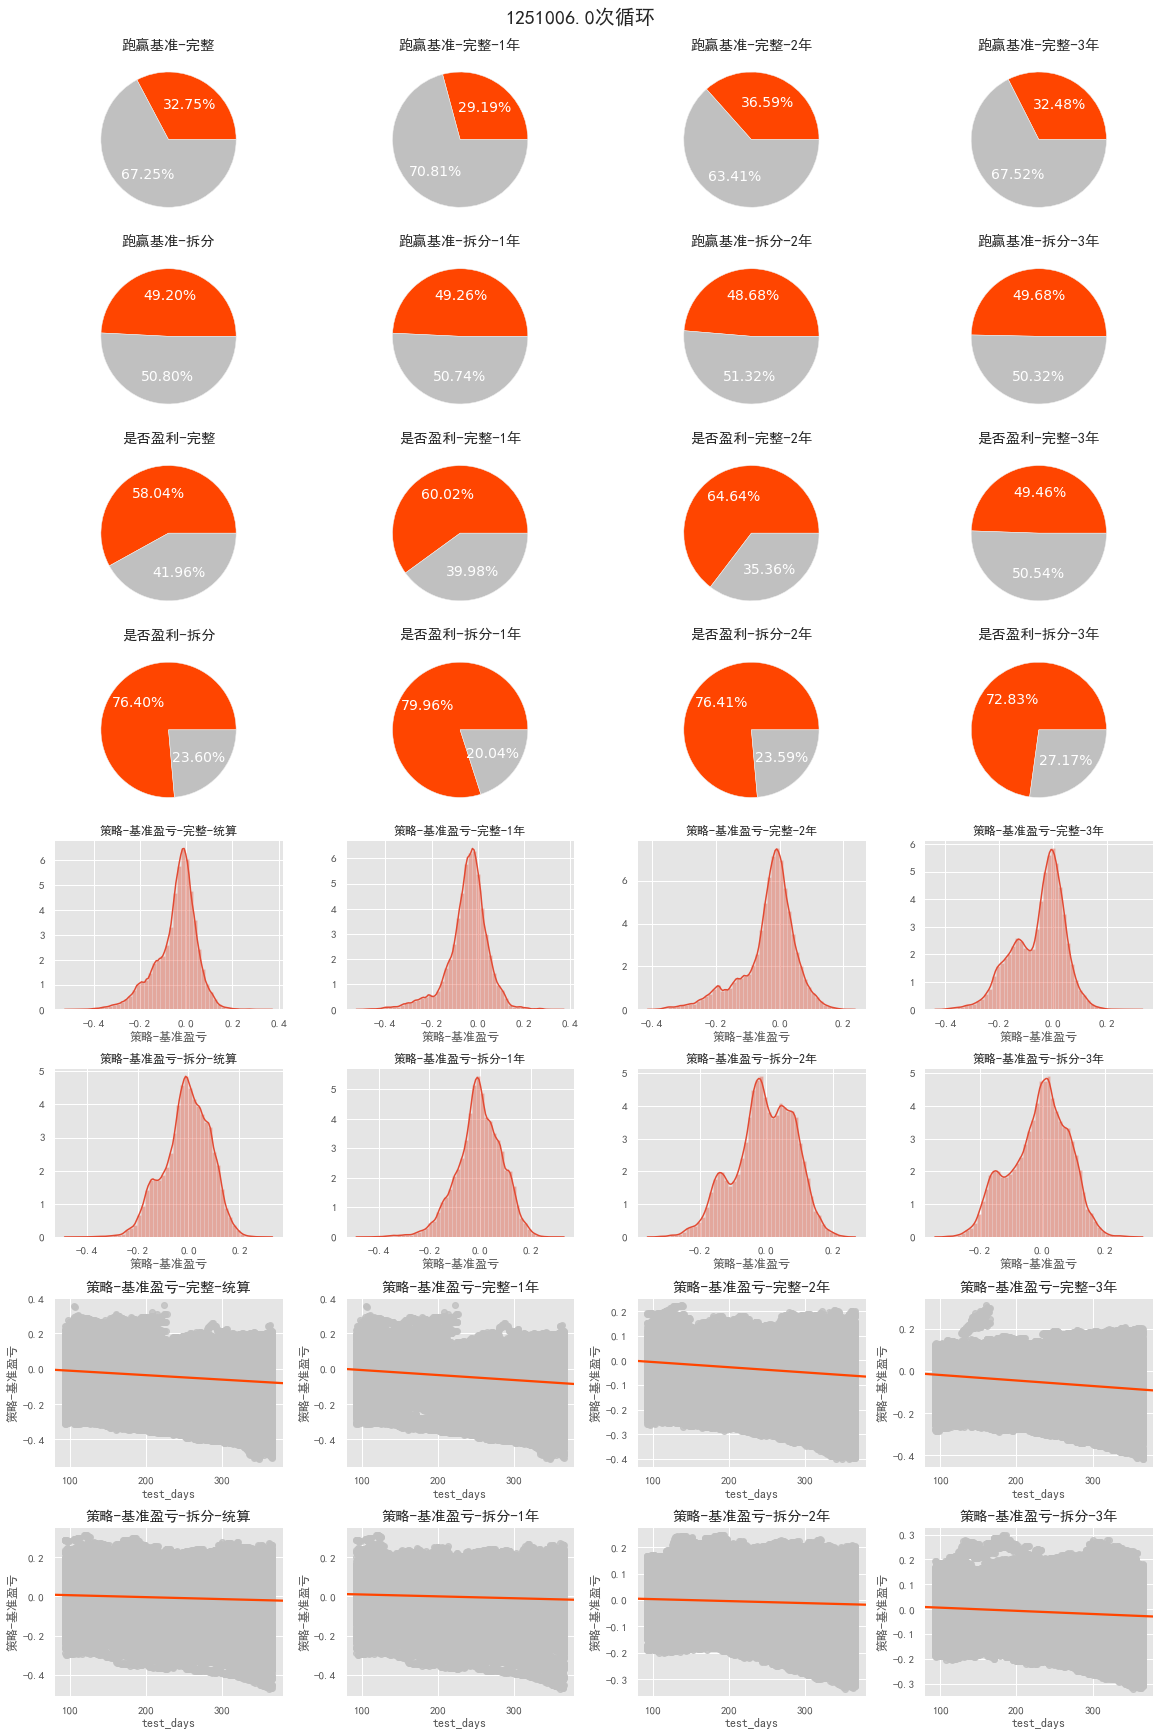

In [18]:
from IPython.display import clear_output
clear_output(wait=True)
report_plot(report)

In [12]:
# sns.relplot(data=report.reset_index(), x="test_days", y="策略-基准盈亏", hue="passyears", col="name")

In [13]:
# report[report['test_days']<200].groupby('name')['策略-基准盈亏'].describe()

In [14]:
# report[report['test_days']<200].groupby('name')['基准最大回撤','策略最大回撤'].agg(['mean','median'])